# Interpreting Hyperspectral Images with LIME: HYPERVIEW Challenge

This notebook demonstrates the usability of the Local Interpretable Model-agnostic Explanations (LIME) algorithm to interpret the predictions of a hyperspectral image regression model. The dataset used in this notebook is from the [HYPERVIEW Challenge](https://ai4eo.eu/challenge/hyperview-challenge/) organized by The European Space Agency (ESA).

The model used in this notebook is one of the top-performing models in the challenge. The trained model architecture is based on the Vision Transformer (ViT) and CLIP (Contrastive Language-Image Pretraining), and its fine-tuned weights are open-sourced under the Apache License in the [Hugging Face Model Hub](https://huggingface.co/KPLabs/HYPERVIEW-VisionTransformer).

**Note**: Before running this notebook, make sure to install the required libraries used in the notebook. The `clip_model` module contains the code needed for additional preprocessing and model loading and can be downloaded from the [Tutorial repository]().


## Table of Contents
- [1. Loading the Model](#1.Loading-the-Model)
- [2. Load the Hyperspectral data from HYPERVIEW Challenge](#2.Load-the-Hyperspectral-data-from-HYPERVIEW-Challenge)
- [3. Convert data into HSI image and preview the images](#3.Convert-data-into-HSI-image-and-preview-the-images)
- [4. Analyze HSI data with LIME](#4.Analyze-HSI-data-with-LIME)
  - [4.1. Spatial Analysis](#4.1.Spatial-Analysis)
  - [4.2. Spectral Analysis](#4.2.Spectral-Analysis)

In [1]:
import torch 
import numpy as np
from tqdm import tqdm
from torchvision import transforms
import matplotlib.pyplot as plt

from clip_model import build_model

import meteors as mt

# print(mt.__name__, mt.__version__)

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 1. Loading the Model

The dataset used for training this model can be found on the official page for the [HYPERVIEW Challenge](https://ai4eo.eu/challenge/hyperview-challenge/).

The following code snippet includes additional functions to load pre-trained CLIP weights and fine-tuned weights for the model.

In [3]:
import os
import hashlib
import urllib
import warnings


BASE_MODEL_URL = "https://openaipublic.azureedge.net/clip/models/b8cca3fd41ae0c99ba7e8951adf17d267cdb84cd88be6f7c2e0eca1737a03836/ViT-L-14.pt"


def download(url: str, root: str, error_checksum: bool = True) -> str:
    os.makedirs(root, exist_ok=True)
    filename = os.path.basename(url)

    expected_sha256 = url.split("/")[-2]
    download_target = os.path.join(root, filename)
    print("INFO: Download Target: {}".format(download_target))

    if os.path.exists(download_target) and not os.path.isfile(download_target):
        raise RuntimeError(f"{download_target} exists and is not a regular file")

    if os.path.isfile(download_target):
        if hashlib.sha256(open(download_target, "rb").read()).hexdigest() == expected_sha256:
            return download_target
        else:
            warnings.warn(f"{download_target} exists, but the SHA256 checksum does not match; re-downloading the file")

    with urllib.request.urlopen(url) as source, open(download_target, "wb") as output:
        with tqdm(
            total=int(source.info().get("Content-Length")), ncols=80, unit="iB", unit_scale=True, unit_divisor=1024
        ) as loop:
            while True:
                buffer = source.read(8192)
                if not buffer:
                    break

                output.write(buffer)
                loop.update(len(buffer))

    if hashlib.sha256(open(download_target, "rb").read()).hexdigest() != expected_sha256:
        if error_checksum:
            raise RuntimeError("Model has been downloaded but the SHA256 checksum does not not match")
        else:
            warnings.warn("Model has been downloaded but the SHA256 checksum does not not match")

    return download_target


def load_base_clip(download_root: str, class_num: int = 1000):
    model_path = download(BASE_MODEL_URL, download_root)
    model = torch.jit.load(model_path, map_location="cpu").eval()
    model = build_model(model.state_dict(), downstream_task=4, class_num=class_num)
    model.float()
    return model

Loads  the pretrained model and sets the model to evaluation mode.

The model can be downloaded from the [Hugging Face Model Hub](https://huggingface.co/KPLabs/HYPERVIEW-VisionTransformer)

In [4]:
download_root = os.path.expanduser("~/.cache/clip") # Change this to the directory where you want to download the model
num_classes = 4  # Number of classes in the original HYPERVIEW dataset

# Load the CLIP model with the HYPERVIEW head
model = load_base_clip(download_root=download_root, class_num=num_classes)

# Load the pre-trained weights
vit_checkpoint_path = download(
    "https://huggingface.co/KPLabs/HYPERVIEW-VisionTransformer/resolve/main/VisionTransformer.pt",
    download_root, error_checksum=False
)
model.load_state_dict(torch.load(vit_checkpoint_path, map_location=device))
model.eval()
model = model.to(device)

INFO: Download Target: /Users/vladimirzaigrajew/.cache/clip/ViT-L-14.pt
INFO: Download Target: /Users/vladimirzaigrajew/.cache/clip/VisionTransformer.pt


/var/folders/33/rj1th5sj2zg3nk1g8kp_7mfh0000gn/T/ipykernel_15238/248559609.py:25: UserWarning: /Users/vladimirzaigrajew/.cache/clip/VisionTransformer.pt exists, but the SHA256 checksum does not match; re-downloading the file
  warnings.warn(f"{download_target} exists, but the SHA256 checksum does not match; re-downloading the file")
100%|█████████████████████████████████████| 1.60G/1.60G [01:35<00:00, 18.0MiB/s]
/var/folders/33/rj1th5sj2zg3nk1g8kp_7mfh0000gn/T/ipykernel_15238/248559609.py:43: UserWarning: Model has been downloaded but the SHA256 checksum does not not match
  warnings.warn("Model has been downloaded but the SHA256 checksum does not not match")


## 2. Load the Hyperspectral data from HYPERVIEW Challenge

For this notebook, we will use the sample images from the HYPERVIEW Challenge dataset. The images are stored in the [tutorial repository]() in the `data` folder. The images are in the `.npy` format. The images are 3D hyperspectral images with 150 bands and various spatial dimensions. The images are stored in the raw format and with the mask applied while training the model.

First, we need to define the loading and preprocessing functions for the data.

In [5]:
def _shape_pad(data):
    max_edge = np.max(data.shape[1:])
    shape = (max_edge, max_edge)
    # padded = np.pad(data, ((0, 0), (0, (shape[0] - data.shape[1])), (0, (shape[1] - data.shape[2]))), "wrap")
    padded = np.pad(data, ((0, 0), (0, (shape[0] - data.shape[1])), (0, (shape[1] - data.shape[2]))), "constant", constant_values=0.0)
    return padded


def load_single_npz_image(image_path):
    with np.load(image_path) as npz:
        data = npz["data"]
        mask = npz["mask"]

        mask = 1 - mask.astype(int)

        mask = _shape_pad(mask)
        data = _shape_pad(data)

        mask = mask.transpose((1, 2, 0))
        data = data.transpose((1, 2, 0))
        data = data / 5419

        return data, mask

def get_eval_transform(image_shape):
    return transforms.Compose(
        [
            
            transforms.Resize((image_shape, image_shape)),
        ]
    )

Now, let's load the hyperspectral image using functions we defined earlier.

In [6]:
data, mask = load_single_npz_image("data/0.npz")
masked_data = data * mask
masked_data = torch.from_numpy(masked_data.astype(np.float32)).permute(2, 0, 1)
eval_tr = get_eval_transform(224)

image_torch = eval_tr(masked_data)
not_masked_image_torch = eval_tr(torch.from_numpy(data.astype(np.float32)).permute(2, 0, 1))

print(f"Original data shape: {data.shape}")
print(f"Original mask shape: {mask.shape}")
print(f"Transformed data shape: {image_torch.shape}")

Original data shape: (89, 89, 150)
Original mask shape: (89, 89, 150)
Transformed data shape: torch.Size([150, 224, 224])


As we can see, the image is a 3D NumPy array with a shape transformed to (150, 224, 224), where 150 is the number of bands and 224x224 is the spatial dimension of the image. We will keep the image in both masked and unmasked formats.

Now, we need to specify the wavelengths of the bands in the image. The wavelengths were provided in the challenge dataset.

In [7]:
wavelengths = [
    462.08, 465.27, 468.47, 471.67, 474.86, 478.06, 481.26, 484.45, 487.65, 490.85,
    494.04, 497.24, 500.43, 503.63, 506.83, 510.03, 513.22, 516.42, 519.61, 522.81,
    526.01, 529.2, 532.4, 535.6, 538.79, 541.99, 545.19, 548.38, 551.58, 554.78,
    557.97, 561.17, 564.37, 567.56, 570.76, 573.96, 577.15, 580.35, 583.55, 586.74,
    589.94, 593.14, 596.33, 599.53, 602.73, 605.92, 609.12, 612.32, 615.51, 618.71,
    621.91, 625.1, 628.3, 631.5, 634.69, 637.89, 641.09, 644.28, 647.48, 650.67,
    653.87, 657.07, 660.27, 663.46, 666.66, 669.85, 673.05, 676.25, 679.45, 682.64,
    685.84, 689.03, 692.23, 695.43, 698.62, 701.82, 705.02, 708.21, 711.41, 714.61,
    717.8, 721.0, 724.2, 727.39, 730.59, 733.79, 736.98, 740.18, 743.38, 746.57,
    749.77, 752.97, 756.16, 759.36, 762.56, 765.75, 768.95, 772.15, 775.34, 778.54,
    781.74, 784.93, 788.13, 791.33, 794.52, 797.72, 800.92, 804.11, 807.31, 810.51,
    813.7, 816.9, 820.1, 823.29, 826.49, 829.68, 832.88, 836.08, 839.28, 842.47,
    845.67, 848.86, 852.06, 855.26, 858.46, 861.65, 864.85, 868.04, 871.24, 874.44,
    877.63, 880.83, 884.03, 887.22, 890.42, 893.62, 896.81, 900.01, 903.21, 906.4,
    909.6, 912.8, 915.99, 919.19, 922.39, 925.58, 928.78, 931.98, 935.17, 938.37
]

## 3. Convert Data into HSI Image and Preview the Images
Now, we will convert the data into a hyperspectral image and preview the images. To create the hyperspectral image, we will use the `HSI` data class from the Meteors module.

The `HSI` class takes the hyperspectral image data, the wavelength data, and the orientation of the image as input and creates the hyperspectral image.

Additionally, we may provide the binary mask, as in our case, to specify where the masked data is present.

In [8]:
# Create a binary mask from the image, where 1 is the masked region and 0 is the unmasked region
binary_mask = (image_torch > 0.0).int()

hsi_0 = mt.HSI(
    image=not_masked_image_torch, # The preprocessed image tensor/numpy
    wavelengths=wavelengths, # The wavelengths list
    orientation="CWH", # The orientation of the image tensor CWH (Channels, Width, Height)
    binary_mask=binary_mask, # The binary mask tensor/numpy
    device=device # The device to use. We can provide it later with the .to(device) method
)

2024-09-15 16:34:20.064 | DEBUG    | meteors.hsi:resolve_inference_device:112 - Device for inference: cpu


Now, let's view the hyperspectral image along with the masked and unmasked versions.

TypeError: visualize_hsi() got an unexpected keyword argument 'use_mask'

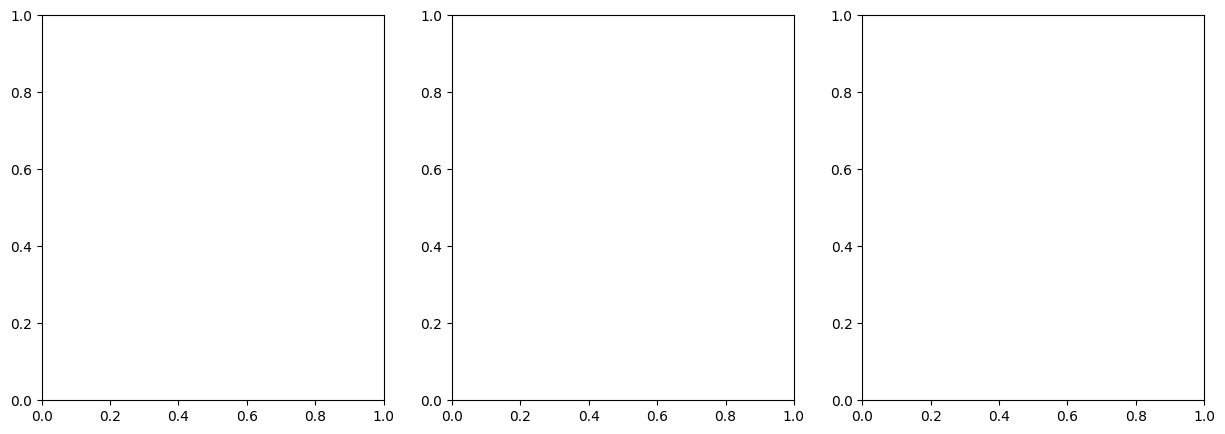

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

mt.visualize.lime_visualize.visualize_hsi(hsi_0, ax1, use_mask=True)
ax1.set_title("Masked Image")

ax2.imshow(binary_mask[0,...].cpu().numpy(), cmap="gray")
ax2.set_title("Binary Mask")

mt.visualize.lime_visualize.visualize_hsi(hsi_0, ax3, use_mask=False)
ax3.set_title("Unmasked Image")

plt.show()

Now, we can provide the hyperspectral image to the model and get the prediction. The model will return the predictions for the 4 classes of the hyperspectral image.

In [10]:
original_prediction = model(not_masked_image_torch.unsqueeze(0))  # original image
hsi_prediction = model(hsi_0.image.unsqueeze(0))  # Hsi image
assert torch.allclose(original_prediction, hsi_prediction, atol=1e-3)

## 4. Analyze HSI Data with LIME
[LIME]((https://dl.acm.org/doi/abs/10.1145/2939672.2939778)) (Local Interpretable Model-agnostic Explanations) is a model-agnostic algorithm that explains the predictions of a model by approximating the model's decision boundary around the prediction. The algorithm generates a set of perturbed samples around the input sample and fits a linear model to the predictions of the perturbed samples. The linear model is then used to explain the prediction of the input sample.

The LIME model in this notebook is tailored to work with hyperspectral data for the following tasks:
- `regression`: The model predicts the continuous values for the hyperspectral image.
- `classification`: The model predicts the class of the hyperspectral image.
- `segmentation`: The model predicts the segmentation mask of the hyperspectral image.

To initialize the LIME object, we need to provide the following parameters:
- `model`: The model used to predict the hyperspectral image and the task type.
- `interpretable_model`: The model used to approximate the decision boundary of the model. In this notebook, we use a Lasso regression model, where the `alpha` parameter is the regularization strength of the Lasso regression model.

In [11]:
explainable_model = mt.utils.models.ExplainableModel(model, "regression") # The model to explain
interpretable_model = mt.utils.models.SkLearnLasso(alpha=0.001) # The interpretable model

lime = mt.Lime(explainable_model, interpretable_model) # The LIME explainer

## 4. Analyze HSI data with LIME
LIME enables to analyze HSI dataset based on the spectral or spatial dimension thus the rest of the notebook will be divided into spectral part and spatial part of HSI data.

### 4.1. Spatial Analysis
Similar to the original implementation of LIME for images, we create spatial superpixels which are perturbed and used to train a surrogate model for explaining. These explanations will produce a correlation map with the output for each superpixel.
First, we need to extract the segmentation mask. We now support three methods to create the mask:
- Using [SLIC](https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_segmentations.html) for superpixel detection
- Using patch segmentation. Knowing that ViT uses squared non-overlapping sliding windows, we can also make superpixels based on the same technique
Providing a custom mask

In this notebook, we will use `slic` and `patch` mask creation methods.

In [12]:
segmentation_mask_slic = lime.get_segmentation_mask(hsi_0, segmentation_method='slic')
segmentation_mask_patch = lime.get_segmentation_mask(hsi_0, segmentation_method='patch', patch_size=14) # the size of the model patch size
assert segmentation_mask_slic.shape == segmentation_mask_patch.shape
assert not torch.equal(segmentation_mask_slic, segmentation_mask_patch)

2024-09-15 16:34:33.719 | WARNING  | meteors.lime:_get_patch_segmentation_mask:1737 - Patch segmentation only works for band_index = 0 now


TypeError: visualize_hsi() got an unexpected keyword argument 'use_mask'

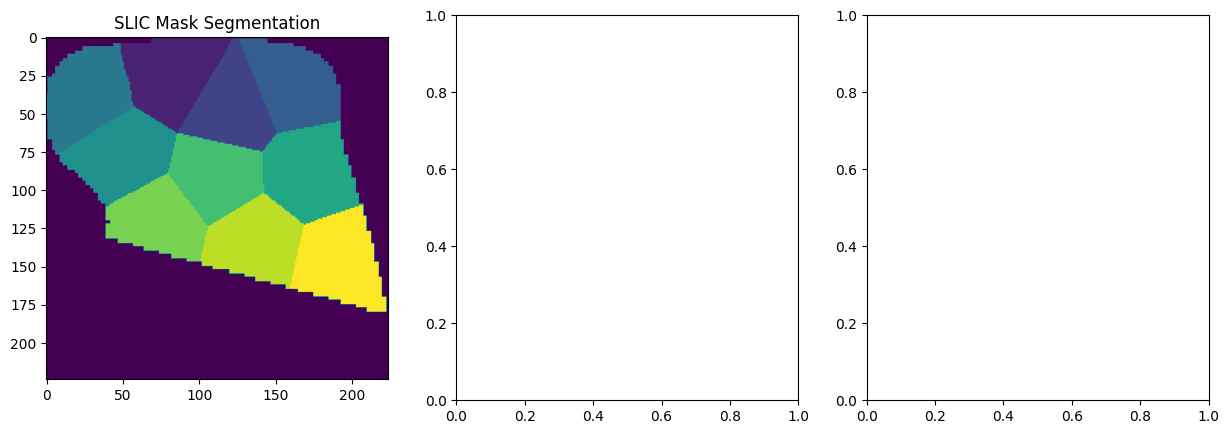

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.imshow(segmentation_mask_slic[0,...])
ax1.set_title("SLIC Mask Segmentation")

mt.visualize.lime_visualize.visualize_hsi(hsi_0, ax2, use_mask=True)
ax2.set_title("HSI Image")

ax3.imshow(segmentation_mask_patch[0,...])
ax3.set_title("Patch Mask Segmentation")

plt.show()

Now that we have our segmentation mask, HSI data prepared, and LIME model, we will train the LIME model to produce attribution maps for the segments. To do this, we need to provide the HSI data, segmentation mask, and target. If our model predicts `n` classes, we need to specify which class we want to analyze. For each class, the analysis of the correlation with segments can be different, so we need to specify the target class.

In [ ]:
spatial_attributes = lime.get_spatial_attributes(
    hsi_0, # HSI data
    segmentation_mask_slic, # Segmentation mask
    target=1, # class analyzed
    n_samples=10, # Number of perturbation, the more the better explainer is trained but the analsys is slower
)

2024-09-15 16:13:27.771 | DEBUG    | meteors.lime:resolve_inference_device:455 - Device for inference: cpu


Our Spatial Attributions object consist now of `hsi` data used for it, `mask` used for creation superpixels and `attributes` produced by the explainer. `attributes` is attribution map for each pixel but to get distinct 2D mask of attrubitons per segemnt we have `flattened_attributes`.

Our Spatial Attributions object now consists of the following:
- `hsi`: The HSI data used for the analysis
- `mask`: The segmentation mask used for creating superpixels
- `attributes`: The attribution map produced by the explainer for each pixel
- `flattened_attributes`: A distinct 2D mask of attributions per segment

We can access these attributes from the `SpatialAttributions` object.

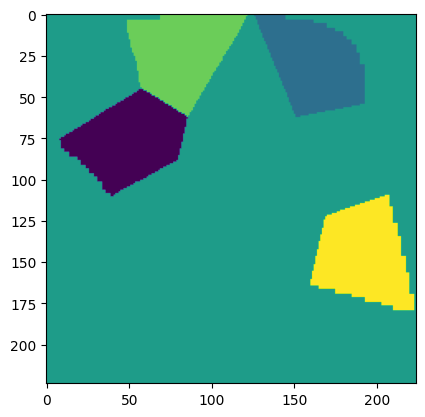

In [ ]:
assert spatial_attributes.hsi == hsi_0
assert torch.equal(spatial_attributes.mask[0], segmentation_mask_slic[0])
assert spatial_attributes.attributes.shape == hsi_0.image.shape

plt.imshow(spatial_attributes.flattened_attributes)
plt.show()

Using the visualization capabilities already provided by meteors, we can easily visualize the LIME results.

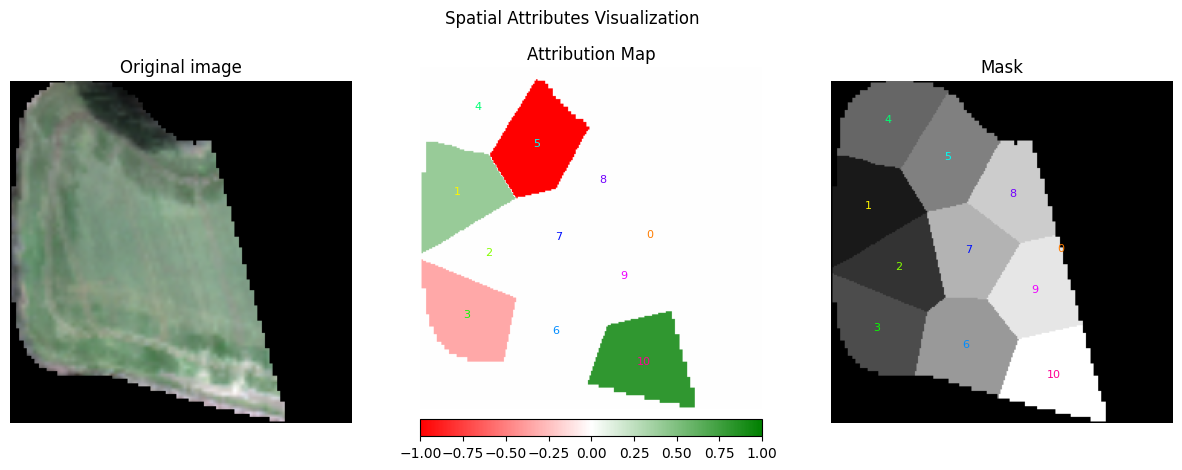

In [ ]:
mt.visualize.visualize_spatial_attributes(spatial_attributes)
plt.show()

The plot presents three components (from the left)
1. On the left, the original image provided to LIME.
2. In the middle, the attribution map for each segment.
3. On the right, the segmented mask with IDs of the segments. The number 0 represents the masked region, and because it surrounds each segment, the placement of the number is in the middle of the segment.

The colors in the attribution map have the following meanings:
- Red: This superpixel is negatively correlated with the input. In our case, it means that the presence of this superpixel contributed to lowering the value for the target class 1.
- White: This segment did not have a significant impact on the output.
- Green: This superpixel is positively correlated with the output. Its presence increases the value for the class `1`.

To validate how well the surrogate model was trained, we also provide the `score` attribute, which indicates the `R2` metric (coefficient of determination) that measures how well the surrogate model was trained.

In [ ]:
spatial_attributes.score

0.9355148673057556

... (oznacza uzupełnij)

Let's analyze the attribution maps for class `0` as well. We can simply modify the `target` parameter and rerun the explanation process.

In [ ]:
spatial_attributes = lime.get_spatial_attributes(hsi_0, segmentation_mask_slic, target=0, n_samples=10)

2024-09-15 16:13:41.052 | DEBUG    | meteors.lime:resolve_inference_device:455 - Device for inference: cpu


R2 metric: 0.8446


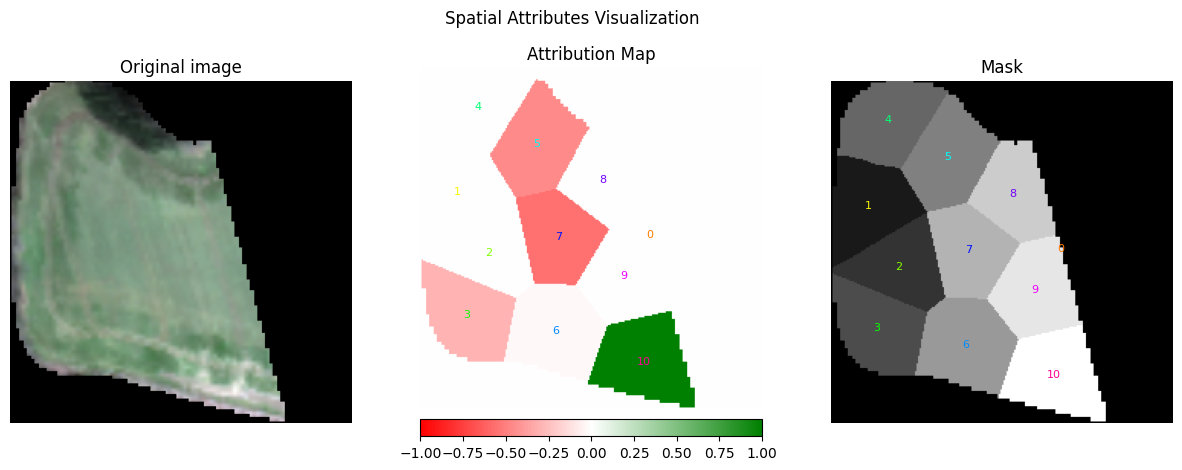

In [ ]:
mt.visualize.visualize_spatial_attributes(spatial_attributes)
print(f"R2 metric: {spatial_attributes.score:.4f}")
plt.show()

...

#### Parameter Checking

Some parameters are more important than others, so let's check how the predictions change based on them.

**1. Segmentation Mask**

One very important parameter is the segmentation mask. Let's check the `patch` segmentation mask and see how it affects the attribution maps.

In [ ]:
spatial_attributes = lime.get_spatial_attributes(hsi_0, segmentation_mask_patch, target=1, n_samples=10)

2024-09-15 16:13:50.723 | DEBUG    | meteors.lime:resolve_inference_device:455 - Device for inference: cpu


R2 metric: 0.9370


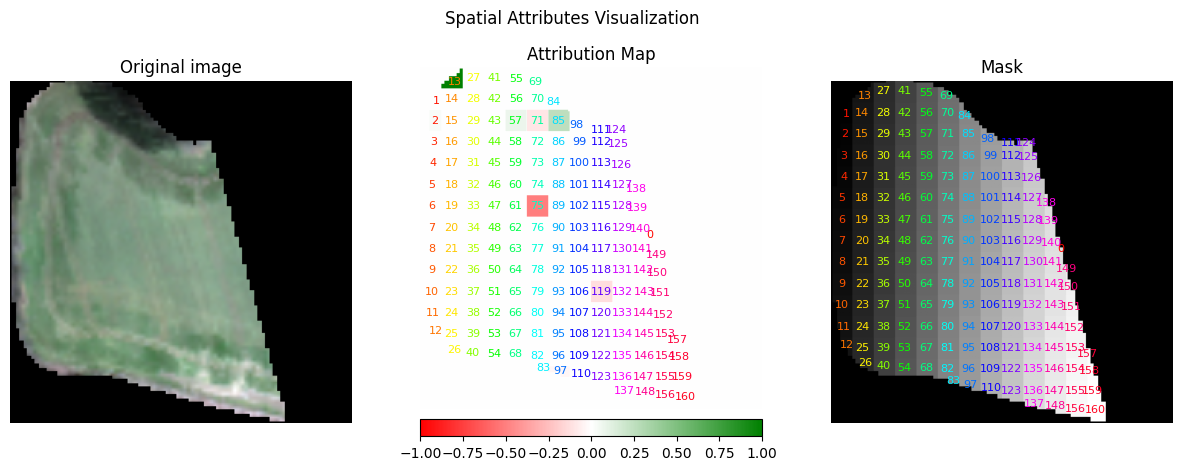

In [ ]:
mt.visualize.visualize_spatial_attributes(spatial_attributes)
print(f"R2 metric: {spatial_attributes.score:.4f}")
plt.show()

...

**2. Number of Samples**

Next let's explore how changing the `n_samples` parameter affects the attribution maps for the patch segments. The `n_samples` parameter determines the number of perturbations the model should produce and teach surrogate model on.

In [14]:
spatial_attributes = lime.get_spatial_attributes(hsi_0, segmentation_mask_patch, target=1,
                                                 n_samples=400)

2024-09-15 16:39:20.052 | DEBUG    | meteors.lime:resolve_inference_device:455 - Device for inference: cpu


R2 metric: 0.4238


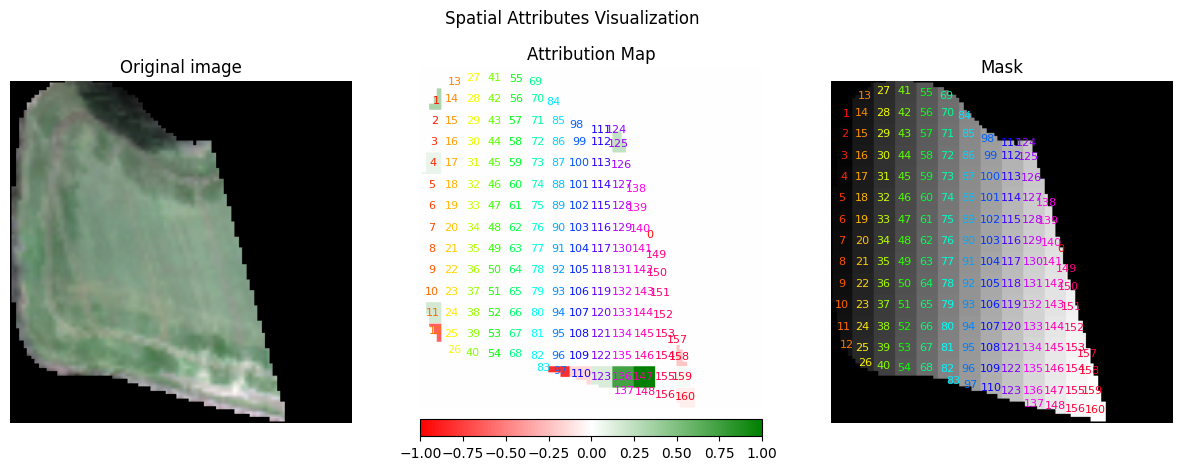

In [15]:
mt.visualize.visualize_spatial_attributes(spatial_attributes)
print(f"R2 metric: {spatial_attributes.score:.4f}")
plt.show()

...

**4. Similarity Function**

We looked into most important parameters in attribution function but lets also check the LIME explainer settings and more precisely the similarity function. As mentioned, LIME aims to explain the local behavior of an example by reweighting the training samples according to their similarity distances. By default, Meteor's LIME uses the exponential kernel on top of the cosine distance. We will change it to Euclidean distance, which is more commonly used in vision tasks.

In [16]:
from captum.attr._core.lime import get_exp_kernel_similarity_function

exp_eucl_distance = get_exp_kernel_similarity_function('euclidean', kernel_width=1000)

lime = mt.Lime(explainable_model, interpretable_model, similarity_func=exp_eucl_distance)

In [17]:
spatial_attributes = lime.get_spatial_attributes(hsi_0, segmentation_mask_slic, target=0, n_samples=10)

2024-09-15 16:39:28.356 | DEBUG    | meteors.lime:resolve_inference_device:455 - Device for inference: cpu


R2 metric: 0.8847


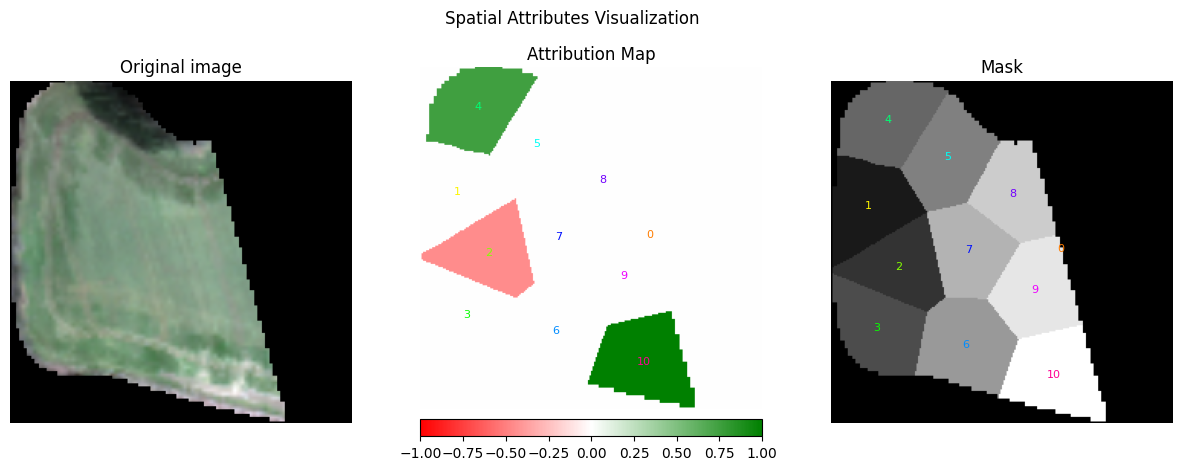

In [18]:
mt.visualize.visualize_spatial_attributes(spatial_attributes)
print(f"R2 metric: {spatial_attributes.score:.4f}")
plt.show()

...

**5. Alpha**

The last important factor that we will check is the `alpha` parameter of the Lasso model. This parameter is a weighting factor for sparsity of the surrogate model. A higher value of `alpha` encourages sparsity, meaning that the model will select fewer superpixels as important features. However, if the `alpha` value is too high, the surrogate model might not learn properly, and we may need to relax the `alpha` parameter to allow for better learning.

In [19]:
lime = mt.Lime(explainable_model, mt.utils.models.SkLearnLasso(alpha=0.0001))

In [20]:
spatial_attributes = lime.get_spatial_attributes(hsi_0, segmentation_mask_slic, target=0, n_samples=10)

2024-09-15 16:39:35.662 | DEBUG    | meteors.lime:resolve_inference_device:455 - Device for inference: cpu


R2 metric: 0.9645


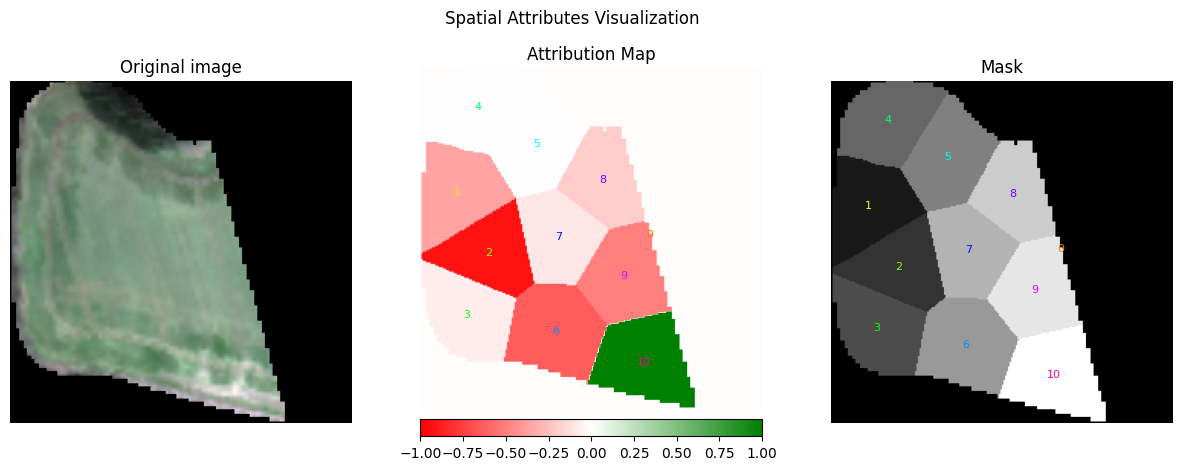

In [21]:
mt.visualize.visualize_spatial_attributes(spatial_attributes)
print(f"R2 metric: {spatial_attributes.score:.4f}")
plt.show()

...

### Spectral Analysis

The spectral analysis is similar to the spatial analysis, but instead of analyzing the spatial dimension of the hyperspectral images, we analyze the spectral dimension. The spectral analysis is useful for understanding the importance of each band in the hyperspectral image. As spatial analysis needs the segmentation mask, the spectral analysis needs the spectral/band mask. 

The spectral mask or as we will call it from now the band mask is a segmentation mask for the superbands. We provide functions to group the bands into superbands which can be done in four ways:
- providing the band mask solely by the user.
- specifying spectral indices or indexes: (['R', 'G'], 'B', 'NIR').
- specifying the wavelength indices {'A': [1,2,4], 'B': [3]} or ranges {'A': (1, 3), 'B': (5, 10)}
- specifying the wavelength values {'A': [450, 500, 600], 'B': [500]} or ranges {'A': (450, 500), 'B': (500, 600)}

In this notebook we will use the `spectral indices` and `wavelength ranges`.

In [22]:
band_mask_indices, band_names_indics = mt.Lime.get_band_mask(hsi_0, band_names=["R", "G", "B"])
band_mask_wavelengths, band_names_wavelengths =  mt.Lime.get_band_mask(hsi_0, band_wavelengths={'A': (400,500), 'B': (500,600), 'C': (600,700)})

2024-09-15 16:39:36.131 | DEBUG    | meteors.lime:get_band_mask:955 - Getting band mask from band names of spectral bands
2024-09-15 16:39:36.133 | DEBUG    | meteors.lime:_get_band_wavelengths_indices_from_band_names:1100 - band_names is a list of segments, creating a dictionary of segments
2024-09-15 16:39:36.136 | DEBUG    | meteors.lime:_create_tensor_band_mask:1427 - Creating a band mask on the device cpu using 3 segments
2024-09-15 16:39:36.138 | WARNING  | meteors.lime:_check_overlapping_segments:1276 - Segments G and B are overlapping on wavelength 510.0299987792969
2024-09-15 16:39:36.139 | WARNING  | meteors.lime:_check_overlapping_segments:1276 - Segments G and B are overlapping on wavelength 513.219970703125
2024-09-15 16:39:36.139 | WARNING  | meteors.lime:_check_overlapping_segments:1276 - Segments G and B are overlapping on wavelength 516.4199829101562
2024-09-15 16:39:36.140 | WARNING  | meteors.lime:_check_overlapping_segments:1276 - Segments G and B are overlapping on

In [23]:
assert band_mask_indices.shape == band_mask_wavelengths.shape
assert len(wavelengths) == band_mask_indices.squeeze(1).squeeze(1).shape[0]
assert len(band_names_indics) == len(band_names_wavelengths) == 3
band_names_indics, band_names_wavelengths

({'R': 1, 'G': 2, 'B': 3}, {'A': 1, 'B': 2, 'C': 3})

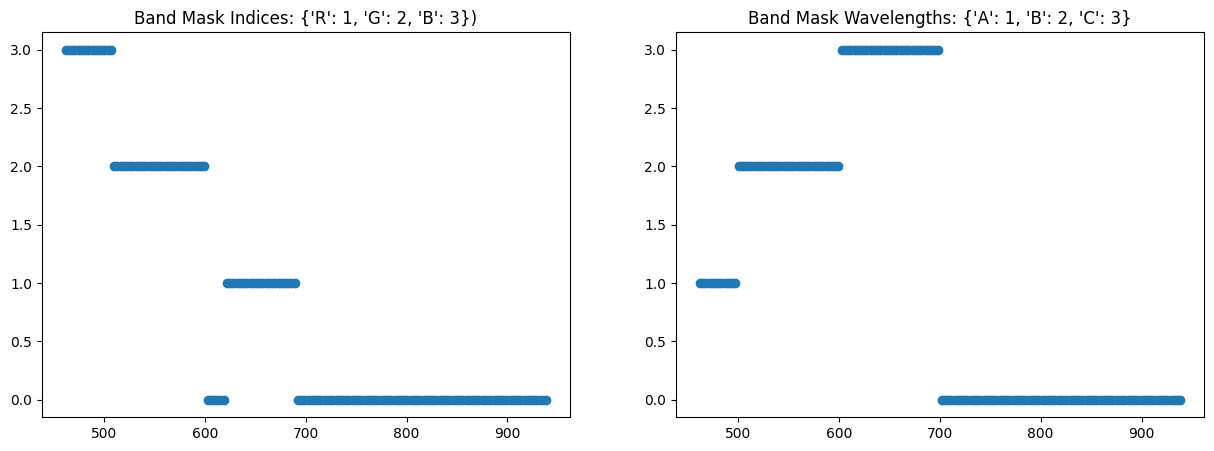

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.scatter(wavelengths, band_mask_indices.squeeze(1).squeeze(1))
ax1.set_title(f"Band Mask Indices: {band_names_indics})")

ax2.scatter(wavelengths, band_mask_wavelengths.squeeze(1).squeeze(1))
ax2.set_title(f"Band Mask Wavelengths: {band_names_wavelengths}")

plt.show()

The plot presents how bands are grouped. The bands with the value 0 creates the additional band group `not_included` which also will be used in the analysis.

Now, we can analyze the hyperspectral image based on the spectral dimension. We will use the same LIME model as in the spatial analysis (initialize with the same parameters), but we will provide the band mask instead of the segmentation mask and also band names.

In [25]:
explainable_model = mt.utils.models.ExplainableModel(model, "regression")
interpretable_model = mt.utils.models.SkLearnLasso(alpha=0.001)

lime = mt.Lime(
     mt.utils.models.ExplainableModel(model, "regression"),
     mt.utils.models.SkLearnLasso(alpha=0.001)
)

In [26]:
spectral_attributes = lime.get_spectral_attributes(
    hsi_0, # HSI data
    band_mask=band_mask_indices, # Band mask
    target=1, # class analyzed
    band_names=band_names_indics, # Band names
    n_samples=10, # Number of perturbation, the more the better explainer is trained but the analsys is slower
)

2024-09-15 16:39:36.567 | DEBUG    | meteors.lime:get_spectral_attributes:1665 - Band names are provided, using them. In future it there should be an option to validate them
2024-09-15 16:39:43.382 | DEBUG    | meteors.lime:resolve_inference_device:455 - Device for inference: cpu


The spectral attributions are similar to spatial attributes consisting of `hsi`, `mask`, `attributes`, and `flattened_attributes`. Now the `flattened_attributes` is the distinct 1D mask of attributions per band.

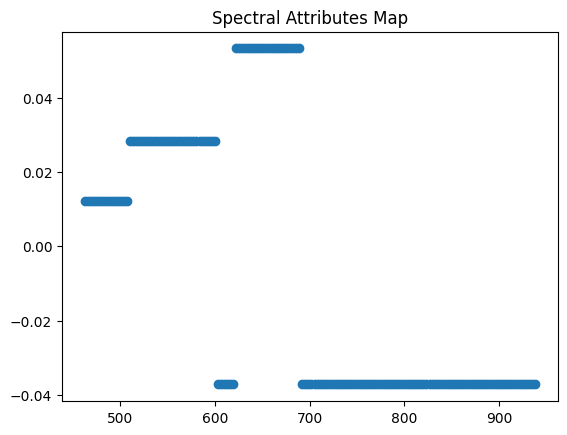

In [27]:
assert len(wavelengths) == spectral_attributes.flattened_attributes.shape[0]
plt.scatter(wavelengths, spectral_attributes.flattened_attributes)
plt.title("Spectral Attributes Map")
plt.show()

But again as with spatial analysis we can visualize the results using the provided Meteors visualization functions.

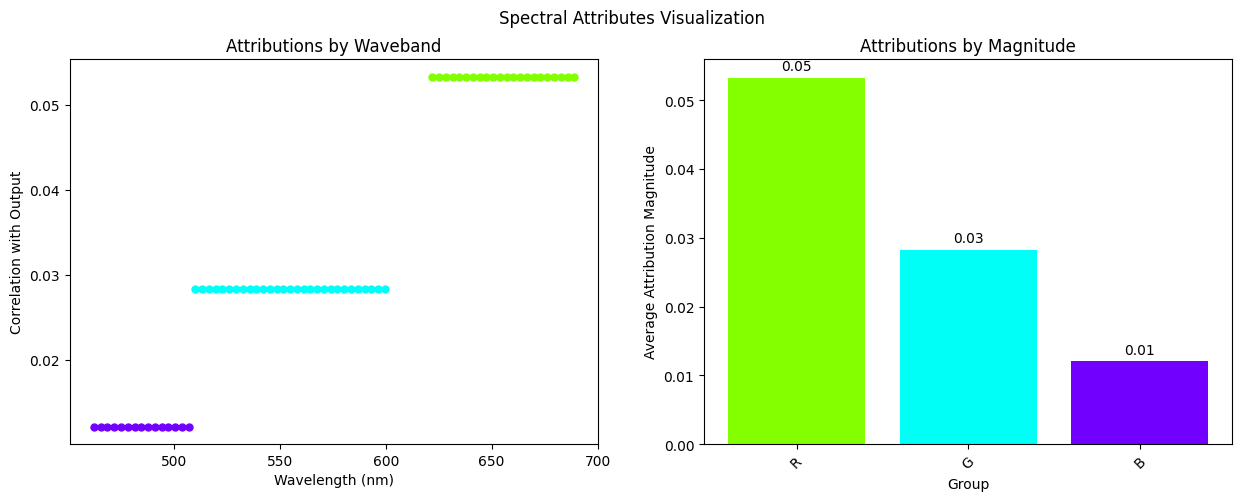

In [28]:
mt.visualize.visualize_spectral_attributes(spectral_attributes, show_not_included=True)
plt.show()

The plot this time consists of two parts. On the left, we have the attribution value per band for the hyperspectral image; on the right, we have the attribution map magnitudes for each superband. On the left, we see similar colors to the right plots marking the same superbands. With the left plot, we are able to see how the bands are important for the model, and on the right, we see how important each superband is.

To validate the model, we have the `score` attribute, which indicates the `R2` metric of how well-trained the surrogate model was.

In [29]:
spectral_attributes.score

0.873772919178009

...

And once again we can check the attributions for the other class, in this case class `0`.

In [30]:
spectral_attributes = lime.get_spectral_attributes(hsi_0, band_mask=band_mask_indices, 
    target=0, band_names=band_names_indics, n_samples=10
)

2024-09-15 16:39:43.798 | DEBUG    | meteors.lime:get_spectral_attributes:1665 - Band names are provided, using them. In future it there should be an option to validate them
2024-09-15 16:39:50.772 | DEBUG    | meteors.lime:resolve_inference_device:455 - Device for inference: cpu


R2 metric: 0.0660


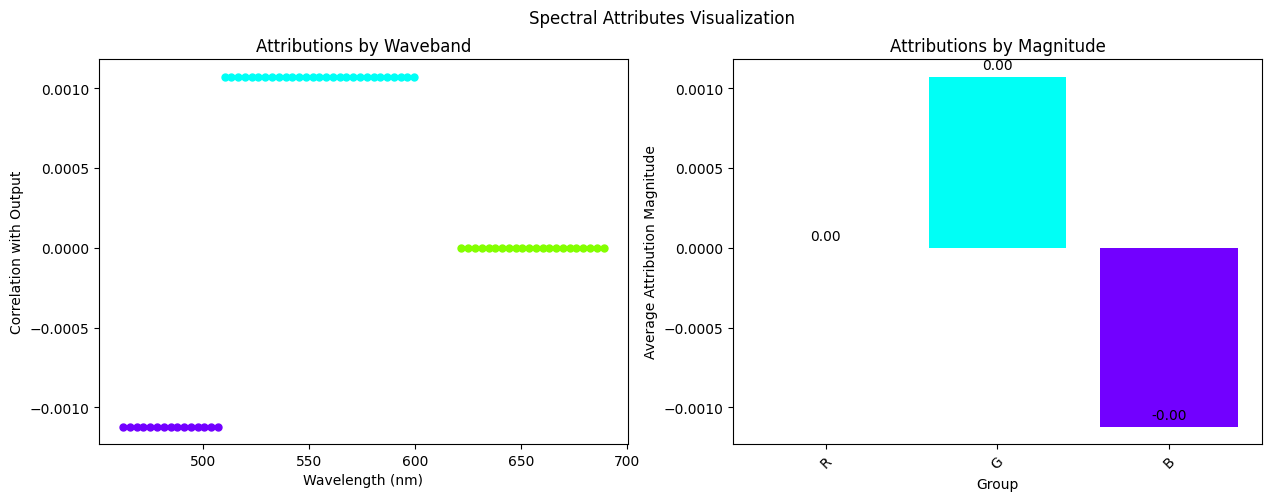

In [31]:
mt.visualize.visualize_spectral_attributes(spectral_attributes, show_not_included=True)
print(f"R2 metric: {spectral_attributes.score:.4f}")
plt.show()

...

And also let's check how the `wavelength ranges` band mask affect the attributions.

In [32]:
spectral_attributes = lime.get_spectral_attributes(hsi_0, band_mask=band_mask_wavelengths, 
    target=0, band_names=band_names_wavelengths, n_samples=10
)

2024-09-15 16:39:51.050 | DEBUG    | meteors.lime:get_spectral_attributes:1665 - Band names are provided, using them. In future it there should be an option to validate them
2024-09-15 16:39:59.147 | DEBUG    | meteors.lime:resolve_inference_device:455 - Device for inference: cpu


R2 metric: 0.8269


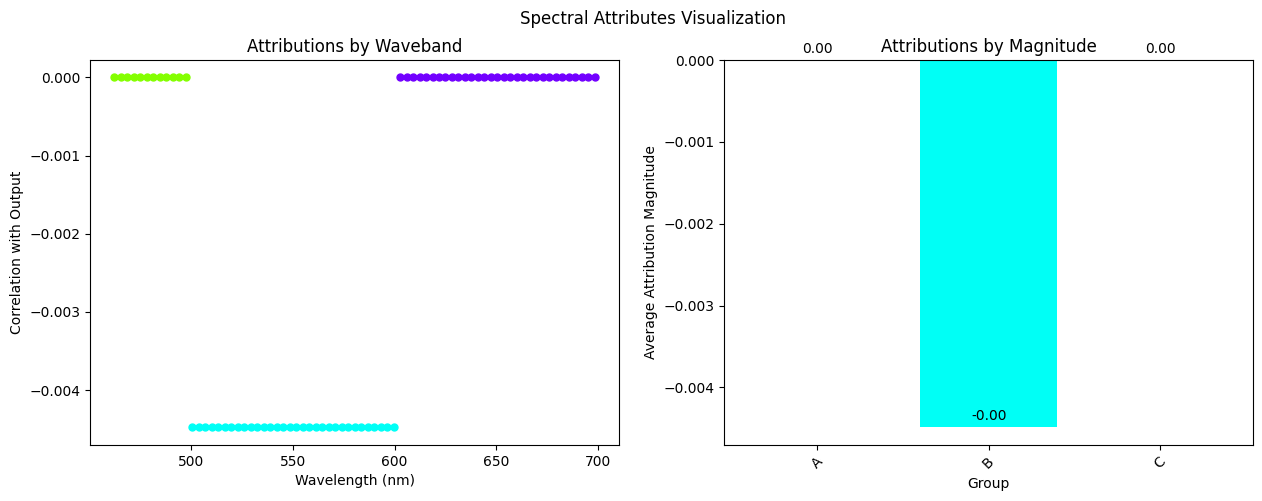

In [33]:
mt.visualize.visualize_spectral_attributes(spectral_attributes, show_not_included=True)
print(f"R2 metric: {spectral_attributes.score:.4f}")
plt.show()

...

As the rest of the most impactful parameters are the same as in spatial analysis we will skip this in the notebook, **but remember that the same parameters can be checked in spectral analysis**.

#### Global Interpretation

An interesting capability unique to spectral analysis is the ability to aggregate results across multiple samples, allowing us to transition from local interpretation to global interpretation.

To achieve this, we need a second sample of the hyperspectral image.

In [34]:
data, mask = load_single_npz_image("data/1.npz")
masked_data = data * mask
masked_data = torch.from_numpy(masked_data.astype(np.float32)).permute(2, 0, 1)
eval_tr = get_eval_transform(224)

image_torch_1 = eval_tr(masked_data)
not_masked_image_torch_1 = eval_tr(torch.from_numpy(data.astype(np.float32)).permute(2, 0, 1))


In [35]:
binary_mask_1 = (image_torch_1 > 0.0).int()

hsi_1 = mt.HSI(
    image=not_masked_image_torch_1,
    wavelengths=wavelengths,
    orientation="CWH",
    binary_mask=binary_mask_1,
    device=device
)

2024-09-15 16:39:59.659 | DEBUG    | meteors.hsi:resolve_inference_device:112 - Device for inference: cpu


Now let's get the attributions for the second sample.

In [36]:
spectral_attributes_1 = lime.get_spectral_attributes(hsi_1, band_mask=band_mask_wavelengths, 
    target=0, band_names=band_names_wavelengths, n_samples=10
)

2024-09-15 16:39:59.672 | DEBUG    | meteors.lime:get_spectral_attributes:1665 - Band names are provided, using them. In future it there should be an option to validate them
2024-09-15 16:40:06.613 | DEBUG    | meteors.lime:resolve_inference_device:455 - Device for inference: cpu


R2 metric: 0.8269


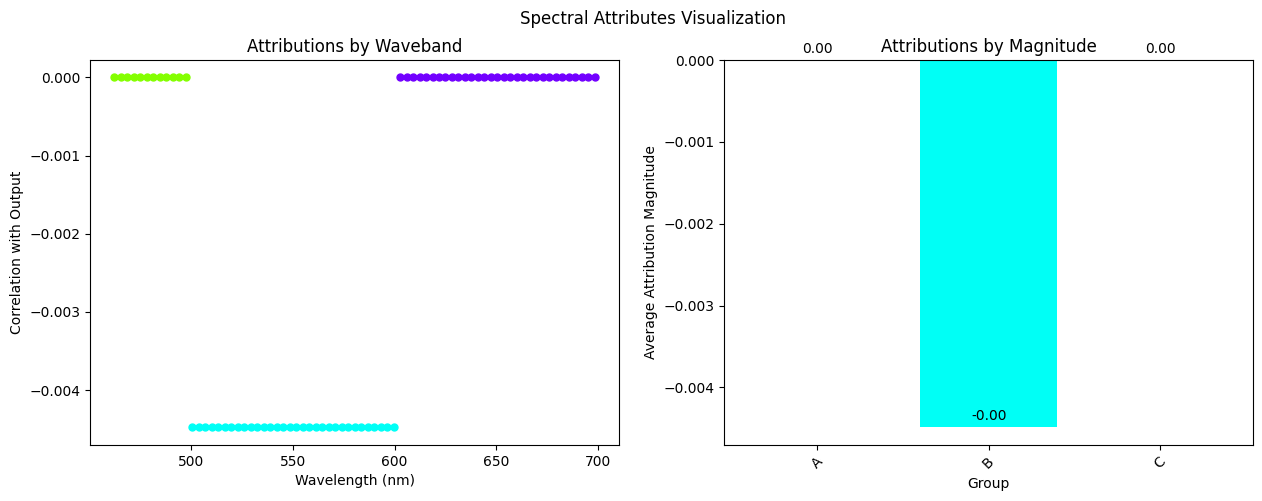

In [37]:
mt.visualize.visualize_spectral_attributes(spectral_attributes, show_not_included=True)
print(f"R2 metric: {spectral_attributes.score:.4f}")
plt.show()

To get the global interpretation we will provide the list of attributions to the meteors visualizer to create the global interpretation visualization.

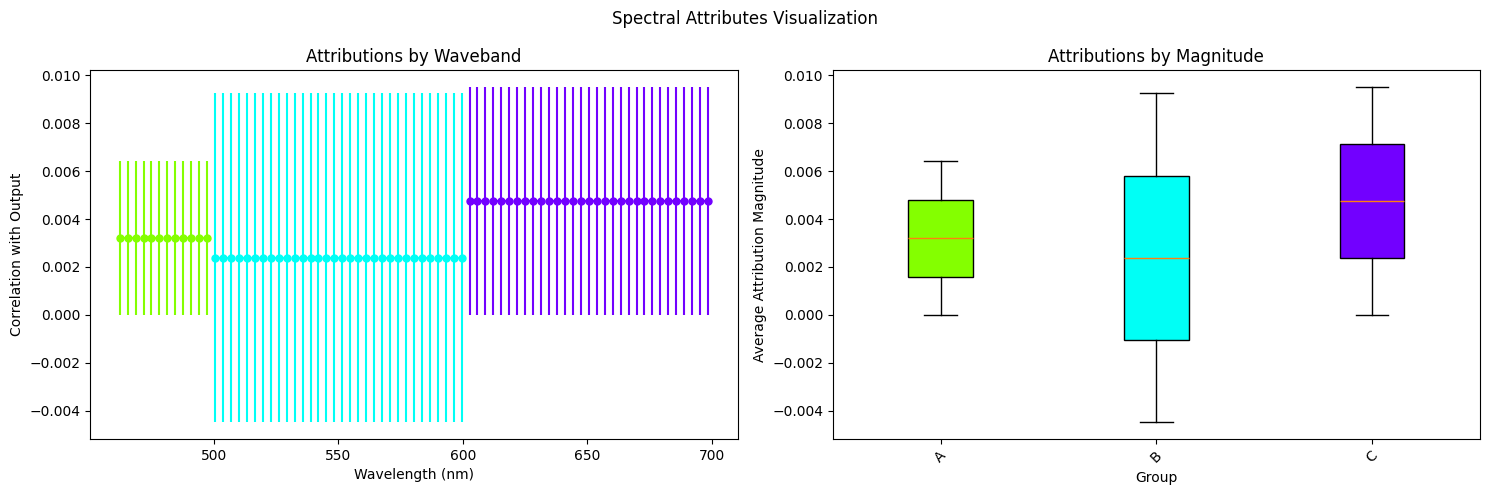

In [38]:
mt.visualize.visualize_spectral_attributes([spectral_attributes, spectral_attributes_1], show_not_included=True)
plt.tight_layout()
plt.show()

...

TODO: Custom aggregation for spatial and spectral

2024-09-15 16:40:07.217 | INFO     | meteors.visualize.lime_visualize:visualize_aggregated_attributes:561 - Band names provided. Using Spectral Analysis.
/Users/vladimirzaigrajew/Documents/projects/meteors/src/meteors/lime.py:181: UserWarning: Band mask contains `0` values which are not covered by the provided band names. Adding 'not_included' to band names.
  warnings.warn(
2024-09-15 16:40:08.084 | DEBUG    | meteors.lime:resolve_inference_device:455 - Device for inference: cpu


(<Figure size 1500x500 with 2 Axes>,
 array([<Axes: title={'center': 'Attributions by Waveband'}, xlabel='Wavelength (nm)', ylabel='Correlation with Output'>,
        <Axes: title={'center': 'Attributions by Magnitude'}, xlabel='Group', ylabel='Average Attribution Magnitude'>],
       dtype=object))

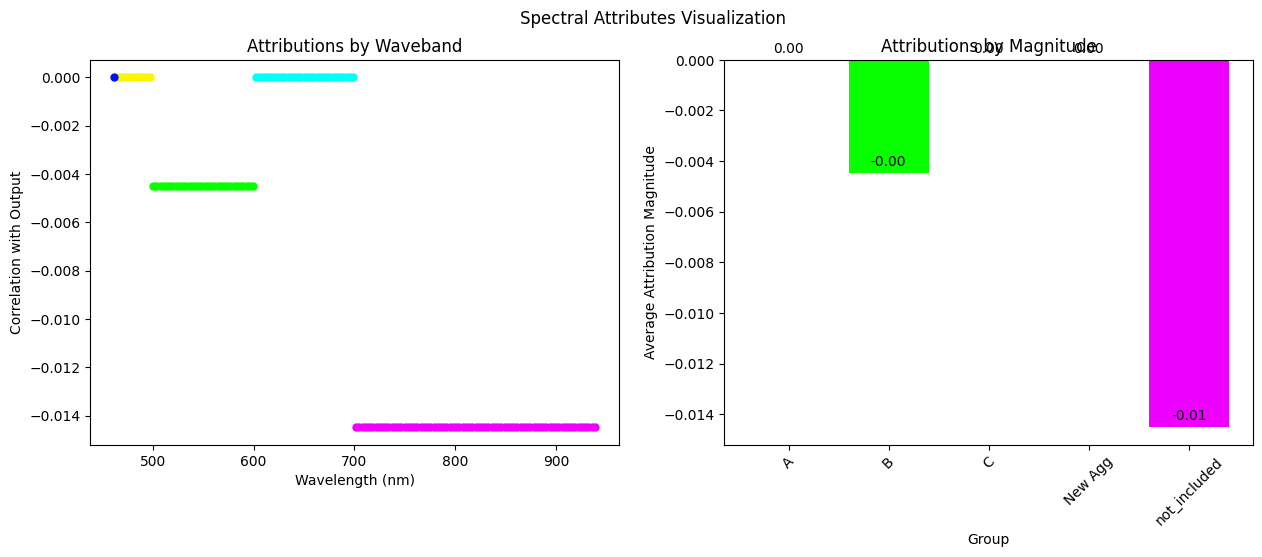

In [39]:
band_mask_custom = band_mask_wavelengths.clone()
band_mask_custom[0]= 4
band_names_custom = band_names_wavelengths.copy()
band_names_custom['New Agg'] = 4

mt.visualize.visualize_aggregated_attributes(spectral_attributes, mask=band_mask_custom, band_names=band_names_custom, show_not_included=True)